# Plot nitrate concentration figure
Plot comparison between observed and Cycles-L predicted nitrate concentration at the WE-38 watershed.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pihm import read_output
from setting import WE38_WATER_QUALITY_OBS, MS_DIR
from my_funcs import nse

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Read observations

In [3]:
# Read observed N concentrations
obs = pd.read_csv(
    WE38_WATER_QUALITY_OBS,
    header=0,
    usecols=[1, 2],
    names=['date', 'conc'],
    parse_dates=['date'],
)
obs.sort_values('date', inplace=True)
obs['doy'] = obs['date'].dt.dayofyear
obs.set_index('date', inplace=True)
obs.dropna(inplace=True)
obs.drop(obs[obs.index < datetime(2000, 1, 1)].index, inplace=True)
obs.drop(obs[obs.index >= datetime(2016, 1, 1)].index, inplace=True)

## Read output and plot

obs mean:  5.417638901003053
WE38 mean:  3.9049293798022084
obs mean:  5.417638901003053
WE38_1dot25xN mean:  5.145879757802683


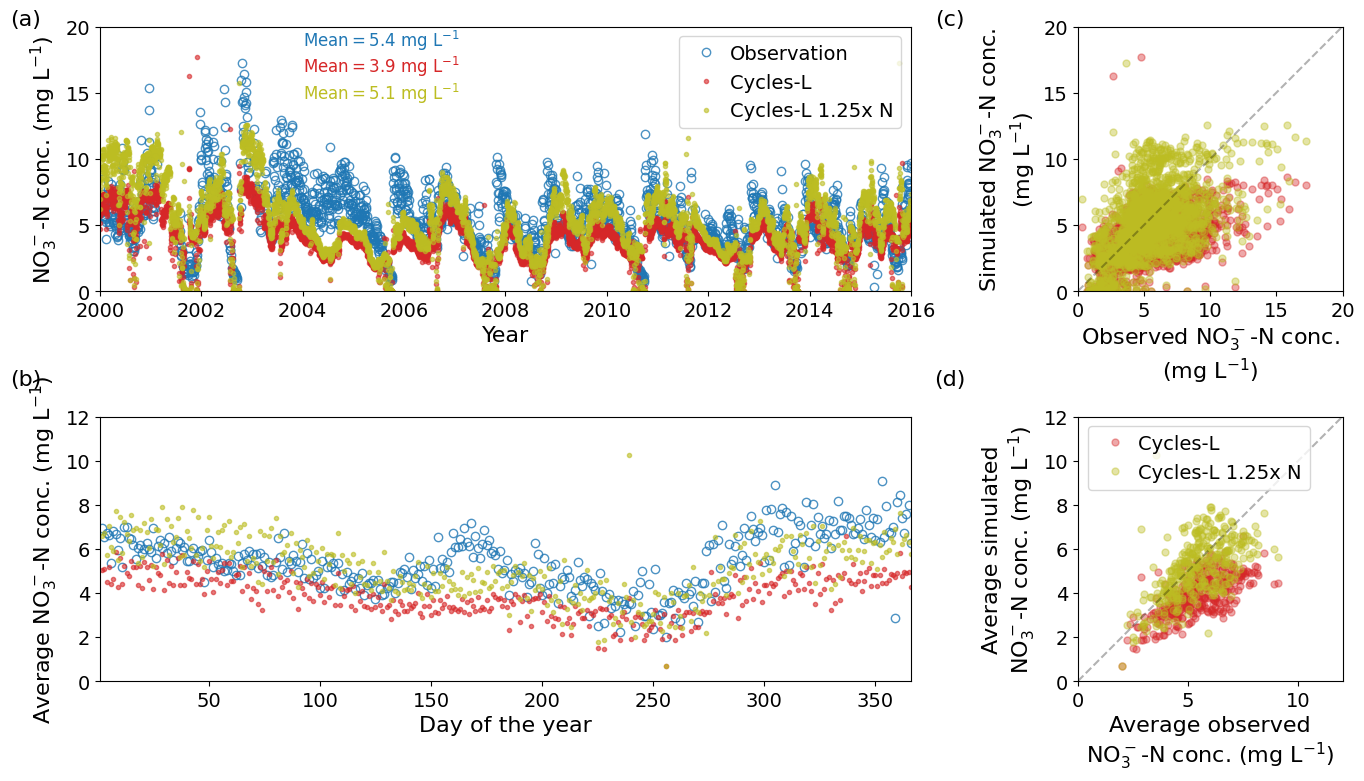

In [4]:
scenarios = {
    "WE38": ["", "#D62728",],
    "WE38_1dot25xN": ["1.25x N", "#BCBD22"],
}

fig = plt.figure(figsize=(14, 8))

axs = []
axs.append(fig.add_subplot(2, 3, (1, 2)))
axs.append(fig.add_subplot(2, 3, (4, 5)))
axs.append(fig.add_subplot(2, 3, 3))
axs.append(fig.add_subplot(2, 3, 6))
lines = []
dots = []

nses = {}
means = {}
_line, = axs[0].plot(obs.index, obs['conc'],
    'o',
    color="#1F77B4",
    mfc='none',
    alpha=0.8,
    label='Observation',
)
#_line, = axs[0].plot(obs.index, obs['conc'],
#    #'o',
#    color="#1F77B4",
#    alpha=0.3,
#    label='Observation',
#)
lines.append(_line)

obs_doy = obs.groupby(obs['doy']).mean()

axs[1].plot(obs_doy.index, obs_doy['conc'],
    'o',
    color="#1F77B4",
    mfc="none",
    alpha=0.8,
)
#axs[1].plot(obs_doy.index, obs_doy['conc'],
#    #'o',
#    color="#1F77B4",
#    alpha=0.3,
#)

for scene in scenarios:
    sim_time, _n_mass, _, _ = read_output('..', 'WE38', scene, 'river.NO3')
    sim_time, _stage, _, _ = read_output('..', 'WE38', scene, 'river.stage')
    sim_time -= timedelta(days=1)
    simulation = pd.DataFrame({'mass': _n_mass[:, 0], 'stage': _stage[:, 0], 'date': sim_time})
    simulation.set_index('date', inplace=True)
    simulation['conc'] = simulation['mass'] / simulation['stage'] * 100

    merged = obs.join(simulation, how='inner', lsuffix='_obs', rsuffix='_sim')

    _dot, = axs[2].plot(merged["conc_obs"], merged["conc_sim"],
        "o",
        color=scenarios[scene][1],
        ms=5,
        alpha=0.4,
        label="Cycles-L " + scenarios[scene][0]
    )
    dots.append(_dot)

    print("obs mean: ", merged["conc_obs"].mean())
    print(f"{scene} mean: ", merged["conc_sim"].mean())
    nses[scene] = nse(merged["conc_obs"], merged["conc_sim"])
    means[scene] = merged["conc_sim"].mean()
    means['obs'] = merged["conc_obs"].mean()
    merged = merged.groupby(merged['doy']).mean()

    axs[3].plot(merged["conc_obs"], merged["conc_sim"],
        "o",
        color=scenarios[scene][1],
        ms=5,
        alpha=0.4,
        label=scenarios[scene][0]
    )

    _line, = axs[0].plot(simulation.index, simulation['conc'],
        '.',
        color=scenarios[scene][1],
        alpha=0.6,
        label='Cycles-L ' + scenarios[scene][0],
    )
    lines.append(_line)

    axs[1].plot(merged.index, merged['conc_sim'],
        '.',
        color=scenarios[scene][1],
        alpha=0.6,
    )

# Set x and y axis labels
axs[0].set_xlabel('Year') 
axs[0].set_ylabel('NO$_3^-$-N conc. (mg L$^{-1}$)')

axs[0].set_ylim(0, 20)
axs[0].set_xlim(datetime(2000, 1, 1), datetime(2016, 1, 1))
## Clean up the x axis dates
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = -18  # pad is in points...

axs[1].set_ylim(0, 12)
axs[1].set_xlim(1, 366)
axs[1].set_xlabel('Day of the year')
axs[1].set_ylabel('Average NO$_3^-$-N conc. (mg L$^{-1}$)')

axs[0].legend(
    handles=lines,
    loc='upper right',
    handletextpad=0.2,
)
axs[3].legend(
    handles=dots,
    loc='upper left',
    handletextpad=0.2,
)
axs[2].plot([0, 50], [0, 50], 'k--', alpha=0.3)
# Set x and y axis labels
axs[2].set_xlabel('Observed NO$_3^-$-N conc.\n(mg L$^{-1}$)')
axs[2].set_ylabel('Simulated NO$_3^-$-N conc.\n(mg L$^{-1}$)')

## Clean up the x axis dates
axs[2].set_ylim(0, 20)
axs[2].set_xlim(0, 20)
axs[2].set_aspect("equal")

axs[3].plot([0, 1000], [0, 1000], 'k--', alpha=0.3)
axs[3].set_xlabel('Average observed\nNO$_3^-$-N conc. (mg L$^{-1}$)')
axs[3].set_ylabel('Average simulated\nNO$_3^-$-N conc. (mg L$^{-1}$)')
axs[3].set_ylim(0, 12)
axs[3].set_xlim(0, 12)
axs[3].set_aspect("equal")

plt.tight_layout()
fig.align_ylabels(axs)

xpos = 0.25
ypos = 0.95
plt.text(
    xpos, ypos, 
    f'$\mathrm{{Mean}} = {means["obs"]:.1f}$ mg L$^{{-1}}$',
    color='#1F77B4',
    size=12,
    ha='left', 
    va='center', 
    transform=axs[0].transAxes,
)
ypos = ypos - 0.1
for s in scenarios:
    plt.text(
        xpos, ypos, 
        f'$\mathrm{{Mean}} = {means[s]:.1f}$ mg L$^{{-1}}$',
        color=scenarios[s][1],
        size=12,
        ha='left', 
        va='center', 
        transform=axs[0].transAxes,
    )
    ypos = ypos - 0.1

fig.text(0.015, 0.97,'(a)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)
fig.text(0.675, 0.97,'(c)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)
fig.text(0.015, 0.52,'(b)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)
fig.text(0.675, 0.52,'(d)', ha='center', va='center', transform=fig.transFigure)#plt.gcf().transFigure)

fig.savefig(f'{MS_DIR}/latex/n_conc.pdf', dpi=300)
fig.savefig(f'{MS_DIR}/figures/n_conc.png', dpi=300)
